In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data/LOG_CHESTXRAY.pdf
/kaggle/input/data/README_CHESTXRAY.pdf
/kaggle/input/data/BBox_List_2017.csv
/kaggle/input/data/test_list.txt
/kaggle/input/data/ARXIV_V5_CHESTXRAY.pdf
/kaggle/input/data/Data_Entry_2017.csv
/kaggle/input/data/train_val_list.txt
/kaggle/input/data/FAQ_CHESTXRAY.pdf
/kaggle/input/data/images_003/images/00006199_010.png
/kaggle/input/data/images_003/images/00004833_016.png
/kaggle/input/data/images_003/images/00006260_000.png
/kaggle/input/data/images_003/images/00004911_010.png
/kaggle/input/data/images_003/images/00004186_007.png
/kaggle/input/data/images_003/images/00004459_000.png
/kaggle/input/data/images_003/images/00005004_001.png
/kaggle/input/data/images_003/images/00005757_000.png
/kaggle/input/data/images_003/images/00004221_001.png
/kaggle/input/data/images_003/images/00004875_000.png
/kaggle/input/data/images_003/images/00005448_001.png
/kaggle/input/data/images_003/images/00005572_000.png
/kaggle/input/data/images_003/images/00005271_00

# Dataset Overview and Basic Visualization

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Visualize a sample image
img = cv2.imread('/kaggle/input/data/images_001/images/00000001_000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title('Sample Chest X-ray')
plt.show()


# Data Exploration

In [9]:
import pandas as pd

df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
print("Total images:", len(df))
df.head()

Total images: 112120


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [10]:
# View Data Columns and Initial Rows
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

# Image Size Distribution Analysis

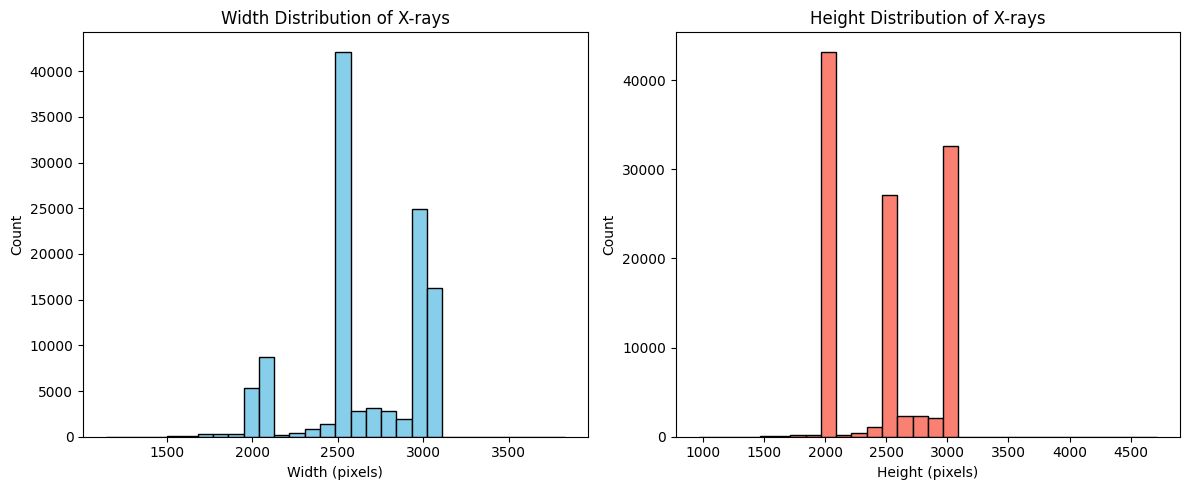

In [12]:
import matplotlib.pyplot as plt
widths = df['OriginalImage[Width'].astype(float)
heights = df['Height]'].astype(float)

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue', edgecolor='black')
plt.title('Width Distribution of X-rays')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon', edgecolor='black')
plt.title('Height Distribution of X-rays')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [13]:
cols_to_keep = ['Image Index', 'Finding Labels', 'Patient ID',
                 'Patient Age', 'Patient Gender', 'View Position']
df = df[cols_to_keep].copy()
print("Cleaned DataFrame shape:", df.shape)
df.iloc[:3]

Cleaned DataFrame shape: (112120, 6)


Image Index          Finding Labels  Patient ID  Patient Age  \
0  00000001_000.png            Cardiomegaly           1           58   
1  00000001_001.png  Cardiomegaly|Emphysema           1           58   
2  00000001_002.png   Cardiomegaly|Effusion           1           58   

  Patient Gender View Position  
0              M            PA  
1              M            PA  
2              M            PA

# Null Values Check

In [14]:
print(df.isnull().sum())

Image Index       0
Finding Labels    0
Patient ID        0
Patient Age       0
Patient Gender    0
View Position     0
dtype: int64


# Multi-Label Binarization of Findings

Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


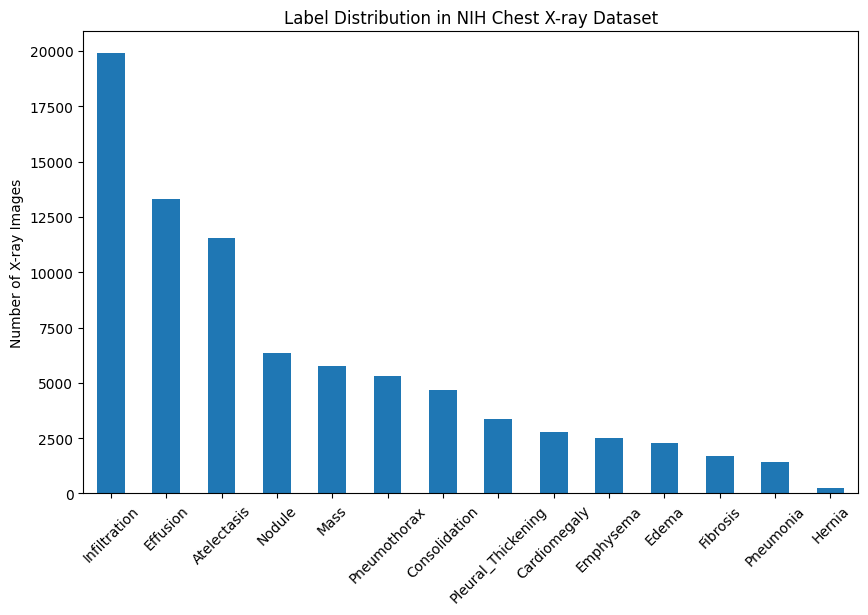

In [15]:
import pandas as pd

all_labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
              'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation',
              'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

for label in all_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

label_counts = df[all_labels].sum().sort_values(ascending=False)
print(label_counts)

plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Label Distribution in NIH Chest X-ray Dataset')
plt.ylabel('Number of X-ray Images')
plt.xticks(rotation=45)
plt.show()

# Multilabel Stratified Split (Test Set - 15%)

In [16]:
!pip install iterative-stratification

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np

# Unique patients for patient-level split
unique_patients = df[['Patient ID', 'Finding Labels']].drop_duplicates(subset='Patient ID').copy()

# Multi-label binarization for patient-level split
patient_labels = []
for pid in unique_patients['Patient ID']:
    labels = df[df['Patient ID'] == pid]['Finding Labels'].unique()
    label_array = np.array([1 if label in '|'.join(labels) else 0 for label in all_labels])
    patient_labels.append(label_array)

patient_labels = np.vstack(patient_labels)

# Stratified Split for Test Set
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, test_idx in mskf.split(unique_patients['Patient ID'], patient_labels):
    test_patient_ids = unique_patients.iloc[test_idx]['Patient ID'].values
    train_val_patient_ids = unique_patients.iloc[train_idx]['Patient ID'].values
    break

test_df = df[df['Patient ID'].isin(test_patient_ids)].copy()
train_val_df = df[df['Patient ID'].isin(train_val_patient_ids)].copy()

print(f"Test images: {len(test_df)}, Train+Val images: {len(train_val_df)}")

Test images: 22639, Train+Val images: 89481


# Multilabel Stratified Split (Train/Validation 85%)

In [17]:
train_val_patients = train_val_df[['Patient ID', 'Finding Labels']].drop_duplicates(subset='Patient ID').copy()

patient_labels = []
for pid in train_val_patients['Patient ID']:
    labels = train_val_df[train_val_df['Patient ID'] == pid]['Finding Labels'].unique()
    label_array = np.array([1 if label in '|'.join(labels) else 0 for label in all_labels])
    patient_labels.append(label_array)

patient_labels = np.vstack(patient_labels)

mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_idx, val_idx in mskf.split(train_val_patients['Patient ID'], patient_labels):
    val_patient_ids = train_val_patients.iloc[val_idx]['Patient ID'].values
    train_patient_ids = train_val_patients.iloc[train_idx]['Patient ID'].values
    break

train_df = train_val_df[train_val_df['Patient ID'].isin(train_patient_ids)].copy()
val_df = train_val_df[train_val_df['Patient ID'].isin(val_patient_ids)].copy()

print(f"Train images: {len(train_df)}, Validation images: {len(val_df)}")

Train images: 71013, Validation images: 18468


# Class Balance Verification After Splitting

In [18]:
print("Train Set:\n", train_df[all_labels].sum().sort_values(ascending=False))
print("\nValidation Set:\n", val_df[all_labels].sum().sort_values(ascending=False))
print("\nTest Set:\n", test_df[all_labels].sum().sort_values(ascending=False))

Train Set:
 Infiltration          12492
Effusion               8454
Atelectasis            7104
Nodule                 4041
Mass                   3659
Pneumothorax           3272
Consolidation          2907
Pleural_Thickening     2113
Cardiomegaly           1725
Emphysema              1558
Edema                  1464
Fibrosis               1098
Pneumonia               921
Hernia                  139
dtype: int64

Validation Set:
 Infiltration          3342
Effusion              2265
Atelectasis           1948
Nodule                1021
Mass                   965
Pneumothorax           965
Consolidation          814
Pleural_Thickening     578
Cardiomegaly           459
Emphysema              448
Edema                  375
Fibrosis               262
Pneumonia              229
Hernia                  48
dtype: int64

Test Set:
 Infiltration          4060
Effusion              2598
Atelectasis           2507
Nodule                1269
Mass                  1158
Pneumothorax          1065


# Handling Class Imbalance with Weighted Loss

### Calculate Class Weights from Train Set

In [19]:
train_samples = len(train_df)

#  Positive and Negative Counts
positive_counts = train_df[all_labels].sum()
negative_counts = train_samples - positive_counts

#  Compute Class Weights (Neg/Pos Ratio)
class_weights = negative_counts / positive_counts

print("Class Weights (Neg/Pos ratio):\n", class_weights.sort_values(ascending=False))

Class Weights (Neg/Pos ratio):
 Hernia                509.884892
Pneumonia              76.104235
Fibrosis               63.674863
Edema                  47.506148
Emphysema              44.579589
Cardiomegaly           40.166957
Pleural_Thickening     32.607667
Consolidation          23.428277
Pneumothorax           20.703240
Mass                   18.407762
Nodule                 16.573125
Atelectasis             8.996199
Effusion                7.399929
Infiltration            4.684678
dtype: float64


### Convert Class Weights to Tensor (PyTorch)

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

print(class_weights_tensor)

#  Weighted BCE Loss Function
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

tensor([  8.9962,  40.1670,   7.3999,   4.6847,  18.4078,  16.5731,  76.1042,
         20.7032,  23.4283,  47.5061,  44.5796,  63.6749,  32.6077, 509.8849],
       device='cuda:0')


### Visualize Class Weights

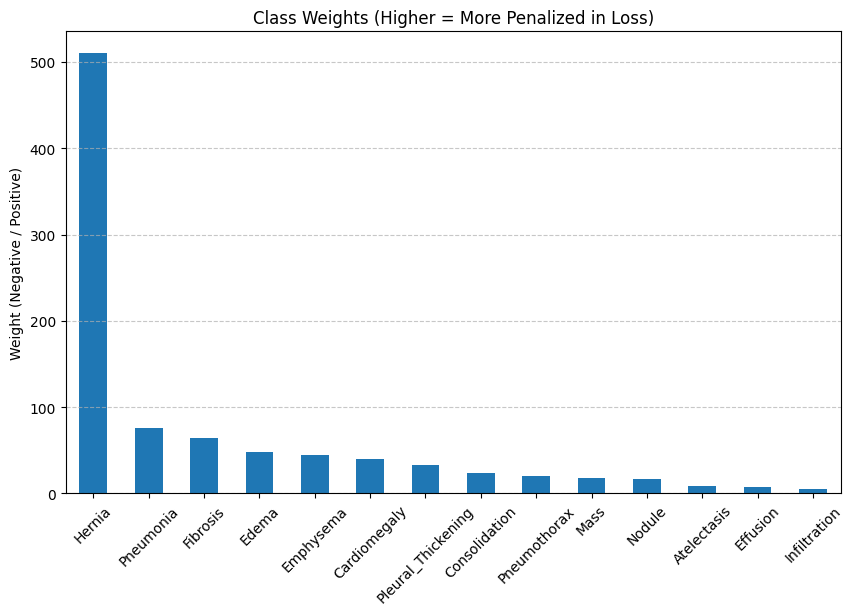

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

weights_series = pd.Series(class_weights.values, index=all_labels).sort_values(ascending=False)

plt.figure(figsize=(10,6))
weights_series.plot(kind='bar')
plt.title('Class Weights (Higher = More Penalized in Loss)')
plt.ylabel('Weight (Negative / Positive)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Compare Original Class Frequency vs Weighted Loss

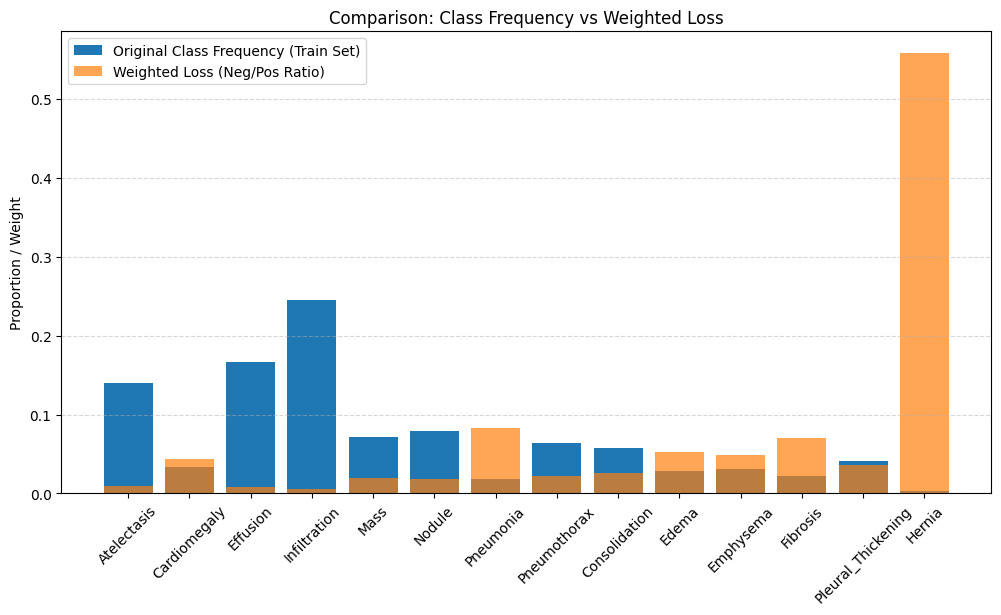

In [22]:
disease_counts = train_df[all_labels].sum()
normalized_counts = disease_counts / disease_counts.sum()
normalized_weights = class_weights / class_weights.sum()

plt.figure(figsize=(12,6))

plt.bar(all_labels, normalized_counts, label='Original Class Frequency (Train Set)')
plt.bar(all_labels, normalized_weights, alpha=0.7, label='Weighted Loss (Neg/Pos Ratio)')

plt.xticks(rotation=45)
plt.ylabel('Proportion / Weight')
plt.title('Comparison: Class Frequency vs Weighted Loss')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Transforms Setup

In [23]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale to [-1,1]
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Custom Dataset Class

In [24]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, labels=None):
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = root_dir  # This should point to /kaggle/input/data/
        self.transform = transform
        self.labels = labels  # List of disease columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_name = row['Image Index']

        # Dynamically search in all subfolders
        image_path = self._find_image_path(image_name)

        image = Image.open(image_path).convert('RGB')
        label = row[self.labels].values.astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, label

    def _find_image_path(self, image_name):
        # Search across images_001 to images_012
        for i in range(1, 13):
            folder = f'images_{i:03d}'
            path = os.path.join(self.root_dir, folder, 'images', image_name)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"{image_name} not found in any subfolder!")


In [25]:
from torch.utils.data import DataLoader

train_dataset = ChestXrayDataset(train_df, '/kaggle/input/data/', transform=train_transform, labels=all_labels)
val_dataset = ChestXrayDataset(val_df, '/kaggle/input/data/', transform=val_transform, labels=all_labels)
test_dataset = ChestXrayDataset(test_df, '/kaggle/input/data/', transform=test_transform, labels=all_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


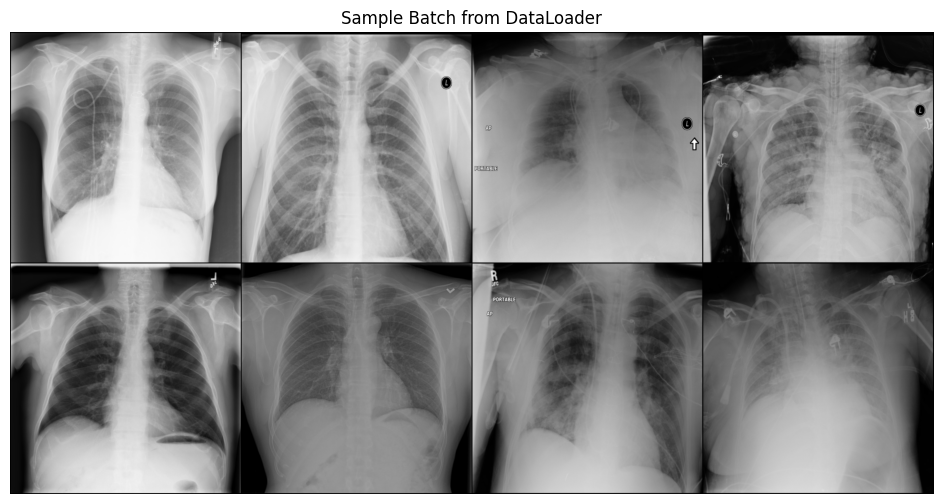

Image 1: No Finding
Image 2: No Finding
Image 3: No Finding
Image 4: No Finding
Image 5: Infiltration, Nodule
Image 6: No Finding
Image 7: Infiltration, Pneumonia, Consolidation, Edema
Image 8: Infiltration, Edema


In [26]:
import matplotlib.pyplot as plt
import torchvision

# Function to display batch
def show_batch(dataloader, label_names, n_images=8):
    images, labels = next(iter(dataloader))
    grid_img = torchvision.utils.make_grid(images[:n_images], nrow=4, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Sample Batch from DataLoader")
    plt.show()

    # Optional: print labels for the first few images
    for i in range(min(n_images, len(labels))):
        active_labels = [label_names[j] for j in range(len(label_names)) if labels[i][j]==1]
        print(f"Image {i+1}: {', '.join(active_labels) if active_labels else 'No Finding'}")

# Example usage
show_batch(train_loader, all_labels)


# Model Setup with AMP + ResNet-18 + Multi-GPU

In [27]:
import torch.nn as nn
import torchvision.models as models
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(all_labels)

#  ResNet-18 
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#  Multi-GPU support
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# ⚡ AMP scaler
scaler = GradScaler()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Using 2 GPUs


/tmp/ipykernel_88/3562501046.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


# AMP-Enabled Training Loop

In [28]:
!pip install tqdm

In [29]:
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0.0

    loop = tqdm(dataloader, desc="Training", leave=True)

    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # ✅ Update tqdm description
        loop.set_postfix({
            'Batch': batch_idx + 1,
            'Loss': loss.item()
        })

    return total_loss / len(dataloader)

#  Validation Loop 

In [30]:
from sklearn.metrics import roc_auc_score

def validate_epoch(model, dataloader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    all_labels = torch.cat(all_labels)
    all_outputs = torch.cat(all_outputs)

    try:
        auc = roc_auc_score(all_labels.numpy(), torch.sigmoid(all_outputs).numpy(), average='macro')
    except:
        auc = 0.0

    return auc


# Training Execution

In [ ]:
epochs = 5

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scaler)
    val_auc = validate_epoch(model, val_loader)

    print(f" Train Loss: {train_loss:.4f} |  Val AUC: {val_auc:.4f}")
    scheduler.step()
    print("="*60)


Epoch 1/5


Training:   0%|          | 0/2220 [00:00<?, ?it/s]/tmp/ipykernel_88/1796793824.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:  56%|█████▋    | 1254/2220 [10:34<06:05,  2.65it/s, Batch=1254, Loss=0.861]

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

In [ ]:
train_losses = []
val_aucs = []
# inside loop:
train_losses.append(train_loss)
val_aucs.append(val_auc)

# after training
plt.plot(train_losses, label='Train Loss')
plt.plot(val_aucs, label='Val AUC')
plt.legend()
plt.title('Training Curve')
plt.show()


In [ ]:
# Load best weights into the model
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

# Evaluate on test set
test_auc = validate_epoch(model, test_loader)
print(f"Test AUC: {test_auc:.4f}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import torch

def evaluate_model_metrics(model, dataloader, all_labels, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > threshold).float()

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    metrics = {
        "Class": [],
        "Precision": [],
        "Sensitivity (Recall)": [],
        "Specificity": [],
        "F1 Score": []
    }

    for i, label in enumerate(all_labels):
        y_true_col = y_true[:, i]
        y_pred_col = y_pred[:, i]

        tn, fp, fn, tp = confusion_matrix(y_true_col, y_pred_col, labels=[0, 1]).ravel()

        precision = precision_score(y_true_col, y_pred_col, zero_division=0)
        recall = recall_score(y_true_col, y_pred_col, zero_division=0)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = f1_score(y_true_col, y_pred_col, zero_division=0)

        metrics["Class"].append(label)
        metrics["Precision"].append(precision)
        metrics["Sensitivity (Recall)"].append(recall)
        metrics["Specificity"].append(specificity)
        metrics["F1 Score"].append(f1)

    return pd.DataFrame(metrics)

# After loading your best model
metrics_df = evaluate_model_metrics(model, test_loader, all_labels)
metrics_df
